In [1]:
ls

sample_data/


In [2]:
from google.colab import drive
drive.mount("aiml")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at aiml


In [3]:
cd /content/aiml/My Drive/

/content/aiml/My Drive


In [4]:
ls

'ChatBot Evaluation.gsheet'  'End to End Scikit Learn Implementation.mp4'
 Classroom/                   Mentors/
'Colab Notebooks'/           'Python For Data Science Edureka.png'


In [ ]:
!cp -r Mentors/Code/Hackathons/FaceRecognition/SiameseCode ./Classroom/

In [ ]:
cd /content/aiml/My Drive/Mentors/Code/Hackathons/FaceRecognition/SiameseCode/SiameseNetwork

/content/aiml/My Drive/Mentors/Code/Hackathons/FaceRecognition/SiameseCode/SiameseNetwork


# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [ ]:

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils

In [ ]:
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch
from torch.autograd import Variable

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

OpenCV - Open Computer Vision Library

cv2.imshow()

cv2.imread()

In [ ]:
import numpy as np
import random

from PIL import Image
import PIL.ImageOps   


## Helper functions
Set of helper functions

Gray Scale Image = 1x32x32 or 32x32x1



In [ ]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

    # TODO : you have to implement the code to save the images based on the flag 'should_save'



In [ ]:
def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [ ]:
pwd

'/content/aiml/My Drive/Mentors/Code/Hackathons/FaceRecognition/SiameseCode/SiameseNetwork'

In [ ]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    # TODO : set the path here if you want add any folder
    train_batch_size = 64 # TODO : Check with different values based on your requirement
    train_number_epochs = 10  # TODO : experiment with different epochs .. accuracy may increase or decrease

initialize the class 'Config' object and access the attributes

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

Siamese Network 

inputs : img1, img2, label

label = 0 [same images, genuine]
label = 1 [different images, imposter]

In [ ]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, imageFolderDataset, transform=None, should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index): # iterate through the class object
        img0_tuple = random.choice(self.imageFolderDataset.imgs) # (img, label)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class: # genuine images
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else: # imposter images
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        label = torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        # TODO : label which 0 (genuine) or 1 (imposter) 
        # classes of img1 and img2 .. if you want to get the classes (from which folder they are coming)
        # change the code here to return required values

        return img0, img1 , label
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [ ]:
train_folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [ ]:
train_folder_dataset

Dataset ImageFolder
    Number of datapoints: 370
    Root location: ./data/faces/training/

In [ ]:
train_siamese_dataset = SiameseNetworkDataset(imageFolderDataset=train_folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor() # apply different transformation techniques here
                                                                      ])
                                       ,should_invert=False)

In [ ]:
train_siamese_dataset

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

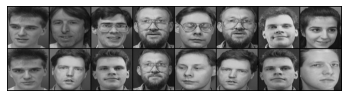

[[0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [ ]:
vis_dataloader = DataLoader(train_siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)

dataiter = iter(vis_dataloader) 


example_batch = next(dataiter) # you are going to get batch_size images
# example_batch = img0, img1 , label

concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated)) 

print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

If you want you can use Lenet, AlexNet or any other network you are interested in

Batch Normalization is one of the regularization techniques which is used to ** avoid overfitting **

you can use Dropout


In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self): # invoked whenever you create an object of this class
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3), # neurons
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)) # neurons in output layer
            # TODO : if you want to get 150 features of each image

    def forward_once(self, x): # custom or user defined funtion
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1) # to bridge convolution layet to fully connected layer
        output = self.fc1(output)
        return output # 

    def forward(self, input1, input2): # invoked whenever you pass the two images img1 and img2 on the object of SiameseNetwork class
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0): # TODO : if you want to increase or decrease the margin or threshold you can do it here
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label): # label = Y
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [ ]:
train_dataloader = DataLoader(train_siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:
train_dataloader

370 train images devided into batches (64 images in each batch)

370/64

In [ ]:
net = SiameseNetwork()


In [ ]:
net

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)

In [ ]:
net = net.cuda()


In [ ]:
criterion = ContrastiveLoss()


In [ ]:
optimizer = optim.Adam(net.parameters(),lr = 0.0005 ) # learnable parameters

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

Streaming output truncated to the last 5000 lines.
        [ 0.5169, -1.2481, -2.6857,  3.5938,  1.8061],
        [-1.5725, -2.1530, -1.2719,  0.2287,  0.5039],
        [ 0.4716, -1.4878, -2.6733,  1.9003,  1.6706],
        [ 0.9643, -0.9992, -0.7397,  1.7425,  1.7643],
        [-0.3573, -0.4860, -2.2926,  0.8656,  0.7326],
        [-1.6957, -1.2842, -1.7631,  2.4223,  0.7527],
        [-0.7240, -0.9761, -1.7576,  1.0688,  0.1527],
        [-0.2042, -1.2098, -1.3891,  2.0424,  0.8355],
        [-1.4577, -0.9035, -1.5306,  1.4655,  0.1740],
        [-1.6167, -1.1344, -0.8003,  2.1732,  0.6845],
        [-1.2981, -0.6694, -1.8486,  2.8193,  0.5067],
        [ 0.2726, -1.1977, -2.9990,  3.2811,  1.5453],
        [-0.7473,  0.2247, -2.6301,  1.6804,  0.4797],
        [ 0.1478, -1.2629, -2.0765,  0.9824,  1.3235],
        [ 0.9985, -2.1272, -2.2024,  1.4087,  1.4517],
        [-1.2305, -1.4043, -1.8733,  2.1253,  0.6148],
        [ 0.5407, -0.9830, -0.7572,  2.3715,  1.5882],
        [ 1.66

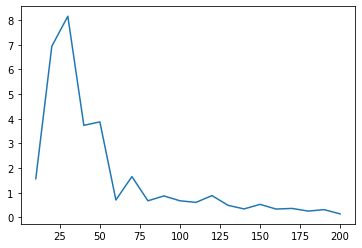

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        # TODO : caputure the other information returned from SiameseNetworkDataset class
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()

        optimizer.zero_grad()

        output1, output2 = net(img0, img1)
        # TODO : to see the features returned you can print it here
        print("output1 ", output1)
        print("output2 ", output2)

        loss_contrastive = criterion(output1, output2, label)

        loss_contrastive.backward() # backpropagation

        optimizer.step() # updating the learnable parameters
        
        if i % 5 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

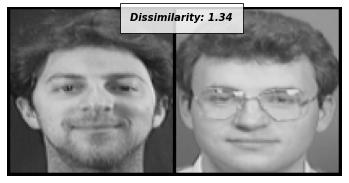

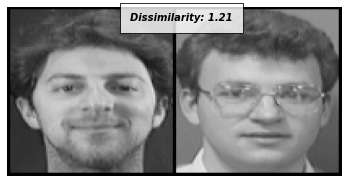

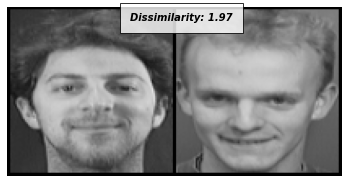

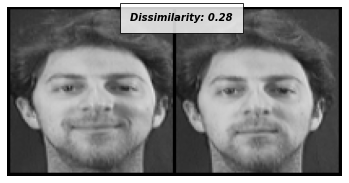

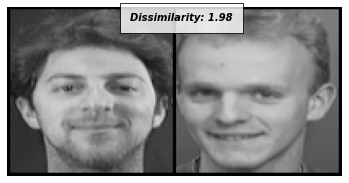

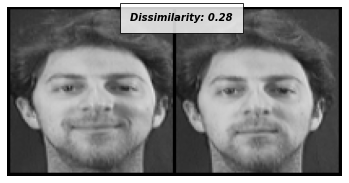

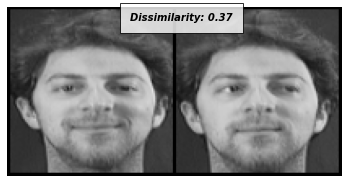

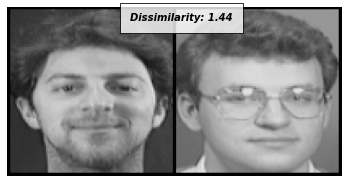

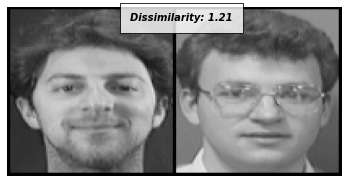

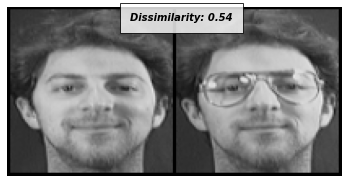

In [ ]:
test_folder_dataset = dset.ImageFolder(root=Config.testing_dir)
test_siamese_dataset = SiameseNetworkDataset(imageFolderDataset=test_folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(test_siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(), Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2) 
    
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



In [ ]:
# TODO : Instead of Dissimilarity Score print Genuine or Imposter